In [38]:
import json
import pandas as pd
import os
import re
import requests
import csv
import matplotlib.pyplot as plt
import numpy as np

DEBUG = False

In [3]:
if not DEBUG:
    df = pd.read_csv('appleAppData.csv')


In [4]:
if DEBUG:
    # create a smaller sample of 1% of the original rows for development purposes 
    !head -1 appleAppData.csv > sample.csv
    !awk 'BEGIN  {srand()} !/^$/  { if (rand() <= .01 || FNR==1) print >> "sample.csv"}' appleAppData.csv
    #
    #
    df = pd.read_csv('sample.csv')

    df.columns

In [5]:
# Filter games only from the dataset
df = df.query("Primary_Genre == 'Games'")
df = df.dropna()
# Drop unneeded columns
df = df.drop(['Primary_Genre', 'Size_Bytes', 'Required_IOS_Version', 'Version', 'Price', 'Currency', 'Developer','Developer_Url','Developer_Website', 'Current_Version_Score', 'Current_Version_Reviews'], axis=1)

In [6]:
# Extract the app store id that can be used for querying the App Store API
def extract_numeric_app_id(row):
    # The app store id is in the format '/id[0-9]{9}' at the end of the URL. 
    # We only want the numeric part of the id, hence the ()'s
    matches = re.findall('id([0-9]{9})', row)
    if len(matches) == 0:
        print('No id found for row ', row)
        return None
    else:
        return matches[0]

df['AppStoreId'] = df['AppStore_Url'].apply(extract_numeric_app_id)
df['AppStoreId']

21         943274708
23         126382794
32         552864558
100        352871101
118        639537194
             ...    
1213920    377912125
1218816    124469544
1221824    154654196
1224010    154045177
1228531    128230260
Name: AppStoreId, Length: 82722, dtype: object

In [7]:
df.shape

(82722, 11)

In [140]:
# tmp extra filtering 
#df = df.head(10)
#df

In [31]:

def getGameDescription(appStoreId):
    itunesUrl = 'https://itunes.apple.com/lookup?id=' + str(appStoreId)
    fields = [None, None, None]
    body = None
    
    # Check local cache before doing a request
    cachePath = 'store_data/' + str(appStoreId) +'.json'
    if (os.path.isfile(cachePath)):
        f = open(cachePath) 
        body = json.load(f)    
    else:  
        try:
            response = requests.get(itunesUrl)
            if (response.status_code == 200):        
                body = json.loads(response.text)
                # write response to cache directory
                with open(cachePath, 'w') as outfile:
                    json.dump(body, outfile)
            else:
                if DEBUG: print ("Failed to retrieve results for " + str(appStoreId))
                return fields

        except requests.exceptions.Timeout:
            print('AppStore request timed out for ' + str(appStoreId))
            raise SystemExit(e)
        except requests.exceptions.RequestException as e:
            # catastrophic error. bail.
            raise SystemExit(e)        
        
    if (body['resultCount'] == 1 ):
        result = body['results'][0]
        if ('genreIds' in result and 'description' in result):
            fields = [
                result['genreIds'], # appStoreGenreIds
                result['description'], # Description
                result['languageCodesISO2A'], # GameLanguages
            ]
        else:
            if DEBUG: print ('Unexpected results')
            if DEBUG: print (body)
    else:   
        if DEBUG: print ("No results found for id " + str(appStoreId))
        return fields
    
    return fields

df[['AppStoreGenreIds', 'Description', 'GameLanguages']] = df.apply(lambda x : getGameDescription(x['AppStoreId']), axis='columns', result_type='expand')
df = df.dropna()
df


/var/folders/6r/9dp8tq351pv6bn5c333l7bhc0000gn/T/ipykernel_43231/3099380153.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['AppStoreGenreIds', 'Description', 'GameLanguages']] = df.apply(lambda x : getGameDescription(x['AppStoreId']), axis='columns', result_type='expand')


,App_Id,App_Name,AppStore_Url,Content_Rating,Released,Updated,Free,DeveloperId,Average_User_Rating,Reviews,AppStoreId,AppStoreGenreIds,Description,GameLanguages,WordCount
21,com.alpigames.fairylandpuzzle,AAA³ Little Ponies & Unicorns,https://apps.apple.com/us/app/aaa-little-ponie...,4+,2014-12-05T08:00:00Z,2016-03-12T15:09:55Z,1.0,419456907.0,5.00000,1.0,943274708,"[6014, 7014, 7002, 6018]",Welcome to the land of fairies in this puzzle ...,"[AR, CA, HR, CS, DA, NL, EN, FI, FR, DE, EL, H...",19.0
100,au.com.tinmangames.gamebookvolume1,GA1: An Assassin in Orlandes,https://apps.apple.com/us/app/ga1-an-assassin-...,12+,2010-02-08T08:00:00Z,2017-09-24T04:49:53Z,0.0,318996102.0,3.20000,5.0,352871101,"[6014, 6018, 7014]",An interactive fantasy adventure! It's a book....,[EN],377.0
118,de.concapptmedia.0056iPhoneKidsComputer,Baby Games App (by HAPPYTOUCH®),https://apps.apple.com/us/app/baby-games-app-b...,4+,2013-05-07T07:00:00Z,2017-09-06T16:38:11Z,1.0,447370352.0,5.00000,1.0,639537194,"[6014, 6018, 7009]","There's plenty to press, touch, move and explo...",[EN],137.0
242,de.concapptmedia.0008iPadKidsComputer,Baby Games from HAPPYTOUCH®,https://apps.apple.com/us/app/baby-games-from-...,4+,2013-05-07T07:00:00Z,2017-05-25T00:43:39Z,1.0,447370352.0,5.00000,1.0,623194607,"[6014, 7009, 6018]","There's plenty to press, touch, move and explo...",[EN],137.0
289,com.eblong.hadeanlands,Hadean Lands,https://apps.apple.com/us/app/hadean-lands/id9...,9+,2014-10-31T18:09:06Z,2018-12-31T13:05:55Z,0.0,457956106.0,5.00000,9.0,918958300,"[6014, 7012, 6018]",*Winner of the XYZZY Interactive Fiction Award...,[EN],226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165471,com.cherrypickgames.touchdownhero.mac,Touchdown Hero: New Season,https://apps.apple.com/us/app/touchdown-hero-n...,4+,2015-11-05T07:27:01Z,2015-11-05T07:27:01Z,0.0,914892983.0,0.00000,0.0,974977700,"[6014, 7016, 6004, 7003]",NEW SEASON is finally here!\n\n- Get on the fi...,[EN],65.0
1167789,com.detentiongames.hiddenobjectsusanewyorkflor...,Hidden Objects USA Time Object,https://apps.apple.com/us/app/hidden-objects-u...,4+,2015-02-21T08:00:00Z,2021-08-08T02:56:24Z,1.0,999167300.0,4.68966,29.0,966960359,"[6014, 7012, 6003, 7014]",Vacation in the USA! Explore beautiful Travel ...,[EN],208.0
1168772,com.mQED.GoldenCherryMac,Slots! Golden Cherry,https://apps.apple.com/us/app/slots-golden-che...,17+,2013-06-27T02:18:13Z,2020-09-09T14:38:36Z,1.0,441029909.0,0.00000,0.0,664618541,"[6014, 7015, 7006, 6004]",The number 1 casino slot machine. It doesn't g...,[EN],119.0
1197497,de.udo-thiel.XAirport,XAirports,https://apps.apple.com/us/app/xairports/id5558...,4+,2012-09-26T17:51:02Z,2020-09-10T23:52:36Z,0.0,551147390.0,0.00000,0.0,555829723,"[6014, 7015, 6002]",XAirports is a utility app that allows owner's...,[EN],274.0


In [9]:
print('Number of rows:', len(df))
df

Number of rows: 13387


,App_Id,App_Name,AppStore_Url,Content_Rating,Released,Updated,Free,DeveloperId,Average_User_Rating,Reviews,AppStoreId,AppStoreGenreIds,Description,GameLanguages
21,com.alpigames.fairylandpuzzle,AAA³ Little Ponies & Unicorns,https://apps.apple.com/us/app/aaa-little-ponie...,4+,2014-12-05T08:00:00Z,2016-03-12T15:09:55Z,True,419456907,5.00000,1,943274708,"[6014, 7014, 7002, 6018]",Welcome to the land of fairies in this puzzle ...,"[AR, CA, HR, CS, DA, NL, EN, FI, FR, DE, EL, H..."
32,com.jhdigitalsolutions.lastenaakkoset,Aakkospeli Lapsille,https://apps.apple.com/us/app/aakkospeli-lapsi...,4+,2012-08-22T20:32:46Z,2015-10-11T14:06:03Z,False,481610881,5.00000,1,552864558,"[6014, 7009, 6018]",Opi aakkosia hauskalla tavalla lasten aakkospe...,[FI]
100,au.com.tinmangames.gamebookvolume1,GA1: An Assassin in Orlandes,https://apps.apple.com/us/app/ga1-an-assassin-...,12+,2010-02-08T08:00:00Z,2017-09-24T04:49:53Z,False,318996102,3.20000,5,352871101,"[6014, 6018, 7014]",An interactive fantasy adventure! It's a book....,[EN]
118,de.concapptmedia.0056iPhoneKidsComputer,Baby Games App (by HAPPYTOUCH®),https://apps.apple.com/us/app/baby-games-app-b...,4+,2013-05-07T07:00:00Z,2017-09-06T16:38:11Z,True,447370352,5.00000,1,639537194,"[6014, 6018, 7009]","There's plenty to press, touch, move and explo...",[EN]
242,de.concapptmedia.0008iPadKidsComputer,Baby Games from HAPPYTOUCH®,https://apps.apple.com/us/app/baby-games-from-...,4+,2013-05-07T07:00:00Z,2017-05-25T00:43:39Z,True,447370352,5.00000,1,623194607,"[6014, 7009, 6018]","There's plenty to press, touch, move and explo...",[EN]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167789,com.detentiongames.hiddenobjectsusanewyorkflor...,Hidden Objects USA Time Object,https://apps.apple.com/us/app/hidden-objects-u...,4+,2015-02-21T08:00:00Z,2021-08-08T02:56:24Z,True,999167300,4.68966,29,966960359,"[6014, 7012, 6003, 7014]",Vacation in the USA! Explore beautiful Travel ...,[EN]
1168772,com.mQED.GoldenCherryMac,Slots! Golden Cherry,https://apps.apple.com/us/app/slots-golden-che...,17+,2013-06-27T02:18:13Z,2020-09-09T14:38:36Z,True,441029909,0.00000,0,664618541,"[6014, 7015, 7006, 6004]",The number 1 casino slot machine. It doesn't g...,[EN]
1197497,de.udo-thiel.XAirport,XAirports,https://apps.apple.com/us/app/xairports/id5558...,4+,2012-09-26T17:51:02Z,2020-09-10T23:52:36Z,False,551147390,0.00000,0,555829723,"[6014, 7015, 6002]",XAirports is a utility app that allows owner's...,[EN]
1203160,mx.com.bingware.QuickPad,QuickPad,https://apps.apple.com/us/app/quickpad/id71245...,4+,2013-10-08T15:01:00Z,2019-11-20T00:06:47Z,True,712451199,0.00000,0,712451196,"[6014, 7006, 6002, 7005]",Esta aplicación es de uso exclusivo para salon...,[EN]


In [32]:
# Filter out non english games (note that this will still leave some non-english game 
# descriptions since the data doesn't always seem to be correct!)
df = df[df['GameLanguages'].str.contains('EN', regex=False)]


In [33]:
if DEBUG: df.to_csv('enriched_sample.csv')
if not DEBUG: df.to_csv('enriched_data.csv')

21         Welcome to the land of fairies in this puzzle ...
100        An interactive fantasy adventure! It's a book....
118        There's plenty to press, touch, move and explo...
242        There's plenty to press, touch, move and explo...
289        *Winner of the XYZZY Interactive Fiction Award...
                                 ...                        
1165471    NEW SEASON is finally here!\n\n- Get on the fi...
1167789    Vacation in the USA! Explore beautiful Travel ...
1168772    The number 1 casino slot machine. It doesn't g...
1197497    XAirports is a utility app that allows owner's...
1203160    Esta aplicación es de uso exclusivo para salon...
Name: Description, Length: 13174, dtype: object


In [37]:
# calculate the word counts for the descriptions 

def get_word_count(desc):
    return len(desc.split())

WordCounts = df['Description'].apply(get_word_count)
df['WordCounts'] = WordCounts
df['WordCounts'].describe()

count    13174.000000
mean       215.768559
std        144.647162
min          1.000000
25%        104.000000
50%        185.500000
75%        291.000000
max        796.000000
Name: WordCounts, dtype: float64

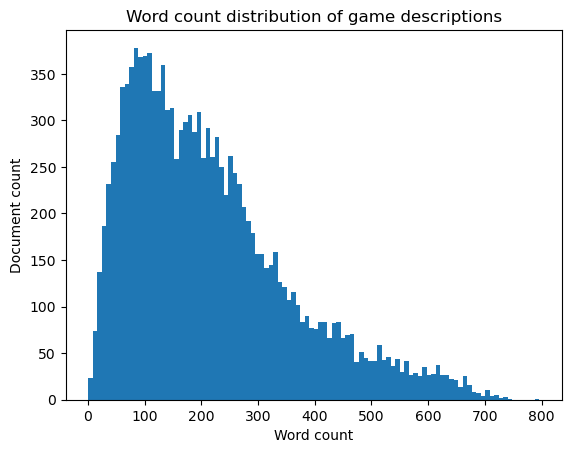

In [56]:
# Histogram about the description lengths
counts, bins = np.histogram(df['WordCounts'], bins=100)
plt.stairs(counts, bins, fill=True)
plt.xlabel('Word count')
plt.ylabel('Document count')
plt.title('Word count distribution of game descriptions')
plt.show()

In [68]:
df.where(df['WordCount'] == 1)['Description'].dropna()

552917    作業TipOn將學生需要練習的作業數位遊戲化。作業TipOn提供不同的遊戲模組，讓學生可以透...
Name: Description, dtype: object

In [71]:
df['AppStoreGenreIds'].describe()


count                  13174
unique                  1621
top       [6014, 7009, 6017]
freq                     222
Name: AppStoreGenreIds, dtype: object

In [128]:
category_mappings = {
    '6000': 'Business',
    '6001': 'Weather',
    '6002': 'Utilities',
    '6003': 'Travel',
    '6004': 'Sports',
    '6005': 'Social Networking',
    '6006': 'Reference',
    '6007': 'Productivity',
    '6008': 'Photo & Video',
    '6009': 'News',
    '6010': 'Navigation',
    '6011': 'Music',
    '6012': 'Lifestyle',
    '6013': 'Health & Fitness',
    '6014': 'Games',
    '6015': 'Finance',
    '6016': 'Entertainment',
    '6017': 'Education',
    '6018': 'Books',
    '6020': 'Medical',
    '6021': 'Newsstand',
    '6022': 'Catalogs',
    '6023': 'Food & Drink',
    '6024': 'Shopping',
    '6027': 'Graphics & Design',
    '7001': 'Game Action',
    '7002': 'Game Adventure',
    '7003': 'Game Casual',
    '7004': 'Game Board',
    '7005': 'Game Card',
    '7006': 'Game Casino',
    '7007': 'Game Dice',
    '7008': 'Game Educational',
    '7009': 'Game Family',
    '7010': 'Game Kids',
    '7011': 'Game Music',
    '7012': 'Game Puzzle',
    '7013': 'Game Racing',
    '7014': 'Game Role Playing',
    '7015': 'Game Simulation',
    '7016': 'Game Sports',
    '7017': 'Game Strategy',
    '7018': 'Game Trivia',
    '7019': 'Game Word'
}
    
# convert the genre ids to genre strings

def convert_genre_id_to_str(id_array):
    genre_strings = [category_mappings[genre_id] for genre_id in id_array]
    return genre_strings

df['AppStoreGenres'] = df['AppStoreGenreIds'].apply(convert_genre_id_to_str)


Statistics about number of genres from the app store metadata
mean    2.547973
min     0.000000
max     3.000000
std     0.629205
Name: AppStoreGenres, dtype: float64


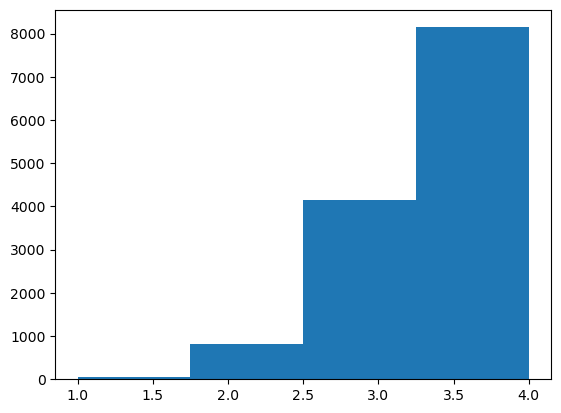

In [129]:
# -1 removes the shared 6014 category that is included in every item
print("Statistics about number of genres from the app store metadata")
print((df['AppStoreGenres'].str.len()-1).agg(['mean','min', 'max','std']))


counts, bins = np.histogram(df['AppStoreGenres'].str.len(), bins=4)
plt.stairs(counts, bins, fill=True)


In [134]:
all_categories = np.array(sum(df['AppStoreGenres'].values.tolist(), []))
# convert codes to readable categories
all_categories = list(filter(lambda x : x != 'Games', all_categories))
# drop the Game category since it's in all items



<AxesSubplot:title={'center':'Distribution of App Store genre labels'}, xlabel='Genre'>

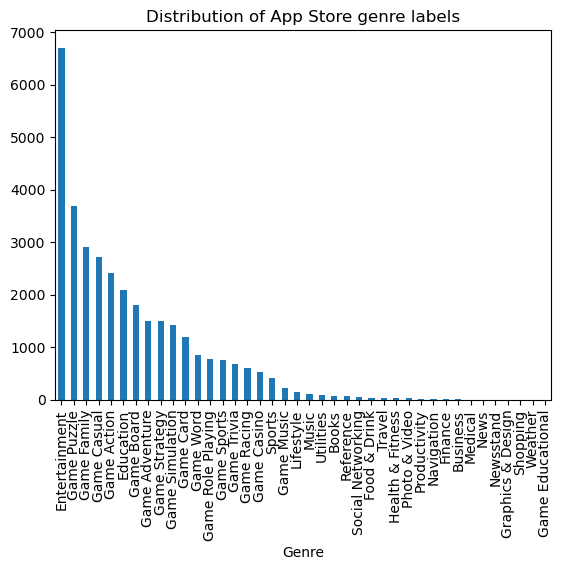

In [157]:
categories_df = pd.Series(all_categories, dtype='category')

categories_df.value_counts().plot.bar(title='Distribution of App Store genre labels', xlabel='Genre')


#plt.hist(all_categories, bins=len(set(all_categories)), fill=True)
#plt.xlabel('Genre')
#plt.xticks(rotation=90)
#plt.title('Distribution of App Store genre labels')
#plt.show()


['Game Role Playing',
 'Game Adventure',
 'Books',
 'Books',
 'Game Role Playing',
 'Books',
 'Game Family',
 'Game Family',
 'Books',
 'Game Puzzle',
 'Books',
 'Game Family',
 'Books',
 'Books',
 'Game Family',
 'Game Family',
 'Books',
 'Game Simulation',
 'Game Family',
 'Books',
 'Books',
 'Game Family',
 'Books',
 'Game Family',
 'Game Word',
 'Game Family',
 'Game Simulation',
 'Books',
 'Game Family',
 'Game Simulation',
 'Books',
 'Books',
 'Game Family',
 'Game Role Playing',
 'Game Family',
 'Books',
 'Game Family',
 'Books',
 'Game Puzzle',
 'Books',
 'Game Family',
 'Game Puzzle',
 'Game Trivia',
 'Entertainment',
 'Books',
 'Game Adventure',
 'Game Strategy',
 'Books',
 'Game Role Playing',
 'Books',
 'Game Role Playing',
 'Books',
 'Game Role Playing',
 'Books',
 'Game Role Playing',
 'Game Adventure',
 'Books',
 'Game Adventure',
 'Game Role Playing',
 'Books',
 'Books',
 'Game Trivia',
 'Books',
 'Game Puzzle',
 'Game Family',
 'Books',
 'Game Role Playing',
 'Books',
